# Evaluating Redshift Predictors on Mock Data

This notebook demonstrates some of the motivations and core functionalities of **FRANKEN-Z**: **F**ull **R**egression over **A**ssociated **N**eighbors with **K**ernel d**E**nsity estimatio**N** for Redshifts (**Z**) by comparing its performance to template fitting-oriented approaches. 

We first outline and demonstrate standard likelihood fitting approaches (e.g., Ilbert et al. 2009) along with the addition of simple Bayesian priors (from BPZ; Benitéz 2000). Once this is done, we then transition to the more realistic (and machine learning-oriented) case where we only have access to a noisy training set of photometry. We then examine how traiditional **scale-free** likelihood fitting (i.e. fitting in color) compare with the more direct **scale-dependent** version (i.e. fitting in mag). Finally, we add in the effects **missing data** can have on our predictions, and demonstrate how to leverage information from the broader sample to "fill in" (i.e. impute) the missing values and derive error estimates.

Note that this code requires BPZ 1.99. Various BPZ routines are used, including the type-magnitude-redshift priors.

We first set up the environment.

In [1]:
import sys # system commands
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d # interpolation
from scipy import stats # statistics functions

# BPZ
bpz_dir = '/Users/Josh/Dropbox/bpz-1.99.3/' # BPZ directory
sys.path.append(bpz_dir)
from prior_hdfn_gen import function as bpz_prior
from bpz_tools import * # loads a bunch of functions from BPZ (note that some of them are weirdly named)

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Now let's import our mock data and templates from the previous notebook.

In [2]:
# load observed data
data=load('mock_catalog_hsc-cosmos.npy')
phot_d=data[:,[0,1,2,3,4]] # fluxes
err_d=data[:,[5,6,7,8,9]] # flux errors
var_d=square(err_d) # flux variances
mask_d=(err_d>0.) # mask for missing data
redshift_d=data[:,10] # redshifts
types_d=data[:,11].astype(int) # types
Nobs=len(data) # number of objects

Nclass=(8,11,12) # passive, spiral, and starburst galaxies, respectively
maglims=[26.5,26.1,25.9,25.1,24.4] # g,r,i,z,y 5-sigma limits for HSC data

Nf=len(phot_d[0]) # number of filters
flux_zeropoint=10**(-0.4*-23.9) # AB magnitude zeropoint
mag_d,magerr_d=fz.asinh_mag_map(phot_d,err_d,zeropoint=flux_zeropoint) # Luptitude mapping

# load model data
models=load('model_catalog_hsc-cosmos.npy')
phot_m=models[:,[0,1,2,3,4]] # fluxes
err_m=zeros(phot_m.shape) # flux errors
var_m=square(err_m) # flux variances
mask_m=ones(phot_m.shape).astype(bool) # mask for missing data
redshift_m=models[:,-2] # redshifts
types_m=models[:,-1].astype(int) # types
Nmodels=len(models) # number of objects

# template grid
Ut,t_inv=unique(types_m,return_inverse=True) # order unique types
Nt=len(Ut) # number of unique types

# redshift grid
Uz,z_inv=unique(redshift_m,return_inverse=True) # ordered unique redshifts
Nz=len(Uz) # number of unique redshifts
dz=Uz[1]-Uz[0]

# discretize redshifts
zidx_m=((redshift_m-Uz[0])/(Uz[1]-Uz[0])).round().astype(int)

Now let's set up FRANKEN-Z.

In [3]:
# master config file
config=fz.ReadParams('config/frankenz.config') 

# import filters
filt=fz.ReadFilters(config.params['FILTERS'],path=config.params['FILTER_PATH'])

# initialize redshift dictionary
rdict=fz.RedshiftDict(config.CONFIG_REDSHIFT.params)

# add names so easier to reference later
rdict.sig_dict=rdict.lze_dict
rdict.sig_width=rdict.lze_width
rdict.delta=rdict.dlz_highres
rdict.grid=rdict.lzgrid_highres
rdict.Ngrid=rdict.Nz_highres

# discretize data
lzidx_d,lzeidx_d=rdict.fit(log(1+redshift_d),ones(Nobs)*rdict.dlz)
lzidx_m,lzeidx_m=rdict.fit(log(1+redshift_m),ones(Nmodels)*rdict.dlz)

# initialize supplementary dictionaries
mdict=fz.PDFDict(config.CONFIG_MAG.params) # magnitude
cdict=fz.PDFDict(config.CONFIG_COLOR.params) # color
midx_d,meidx_d=mdict.fit(mag_d,magerr_d)

This is the underlying catalog, which extends to below the magnitude ranges we can hope to probe due to noise detection limits and selection functions. Let's apply a basic selection function here as simply a cut in $i$-band magnitude.

In [6]:
sel=(mag_d[:,2]<maglims[2]) # applying i-band cut
Nsel = sel.sum() # number of galaxies post-cut
print 'Number of observed galaxies (all):',Nobs
print 'Number of observed galaxies (selected):',Nsel
print 'Number of models:',Nmodels

Number of observed galaxies (all): 500000
Number of observed galaxies (selected): 181162
Number of models: 18631


Let's visualize the impact this cut has on our sample. FRANKEN-Z has the ability to compute probability distribution functions (PDFs) based on **kernel density estimation (KDE)** using a dictionary of Gaussian PDFs, so we'll take advantage of that to incorporate errors into our density estimates.

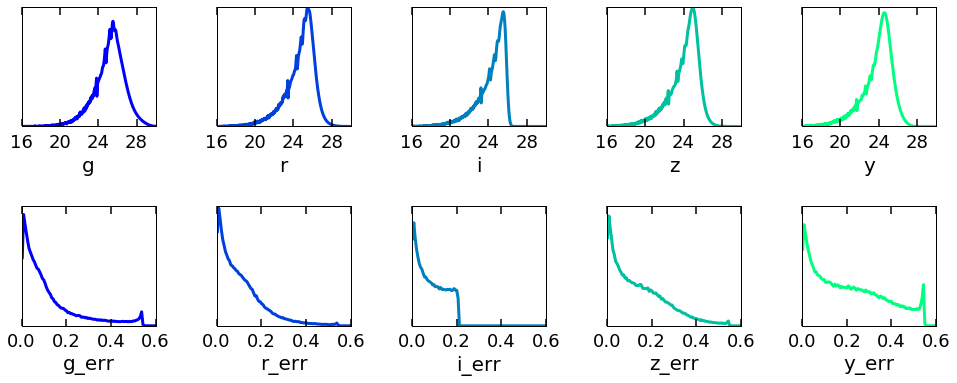

In [7]:
# plotting magnitude distribution
fcolors=get_cmap('winter')(linspace(0,1,Nf)) # filter colors
figure(figsize=(14,6))
for i in xrange(Nf):
    subplot(2,Nf,i+1)
    mag_pdf=fz.pdf_kde_dict(mdict.sig_dict,mdict.sig_width,midx_d[:,i],meidx_d[:,i],sel.astype(int),
                            mdict.grid,mdict.delta,mdict.Ngrid) # smooth PDF generated using input dictionaries
    plot(mdict.grid,mag_pdf,lw=3,color=fcolors[i])
    xlim([16,30])
    yticks([])
    xticks(arange(16,30,4),fontsize=18)
    xlabel(filt.filters[i],fontsize=20)
    tight_layout()
    subplot(2,Nf,i+1+Nf)
    h,bins=histogram(magerr_d[:,i][sel],normed=True,range=[0,0.6],bins=100)
    plot((bins[:-1]+bins[1:])/2.,h,lw=3,color=fcolors[i])
    xticks(linspace(0,0.6,4),fontsize=18)
    xlabel(filt.filters[i]+'_err',fontsize=20)
    yticks([])
    tight_layout()

Note that the error "spike" seen at $\sim 0.5$ is a result of our usage of asinh magnitudes (i.e. "Luptitudes"; Lupton et al. 1999) rather than log10 magnitudes to incorporate data with negative measured fluxes. It traces the intrinsic sky background. 

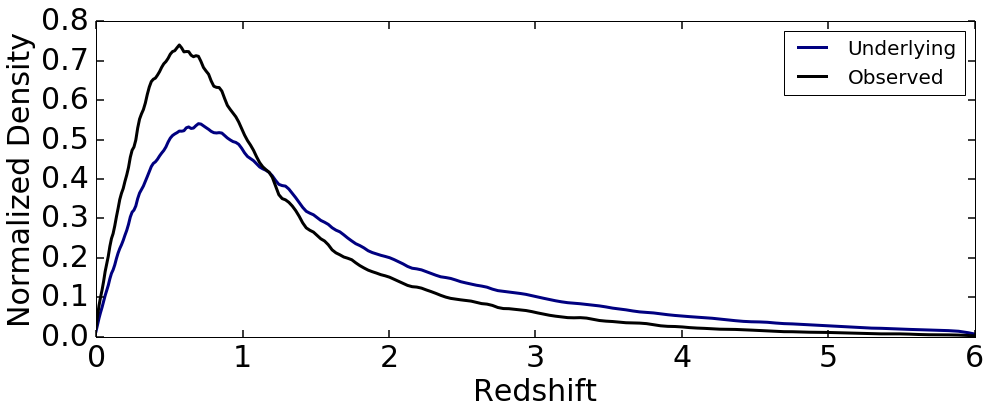

In [9]:
# plotting redshift distribution
figure(figsize=(14,6))

# all
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_d,lzeidx_d,ones(Nobs),
                      rdict.grid,rdict.delta,rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)] # truncating edges
z_pdf/=rdict.znorm # converting from log(1+z) to z density
z_pdf/=trapz(z_pdf,rdict.zgrid) # normalizing
plot(rdict.zgrid,z_pdf,lw=3,color='navy',label='Underlying')

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_d,lzeidx_d,sel.astype(int),
                      rdict.grid,rdict.delta,rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf/=trapz(z_pdf,rdict.zgrid)
plot(rdict.zgrid,z_pdf,lw=3,color='black',label='Observed')

xlim([Uz.min(),Uz.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Density')

As expected, our selection effect has a huge impact on our inferred redshift distribution, which differs markedly from the underlying distribution.

## Likelihood fitting with models

First we investigate the **ideal case** where we know the underlying models (**and priors**) used to generate the data. This is similar to the assumptions typically made in photometric redshift (photo-z) template-fitting codes. Using a basic grid in template/redshift, we use brute-force methods to compute photo-z PDFs using **scale-free likelihoods** (i.e. fitting in color) both with and without incorporating BPZ priors.

In [16]:
downsample=20 # downsample the data since likelihood computation is relatively slow
Nsub=Nsel/downsample+1

# Redshift PDFs and -2ln(evidence) (raw)
zpdf_raw=empty((Nsub,Nz))
levidence_raw=empty(Nsub)

# Redshift PDFs and -2ln(evidence) (BPZ)
zpdf_bpz=empty((Nsub,Nz))
levidence_bpz=empty(Nsub)

sel_arr=arange(Nobs)[sel][::downsample]
for count in arange(Nsub):
    if count%100==0: sys.stdout.write(str(count)+' ')
    i=sel_arr[count] # counter
    ll,Nbands=fz.loglikelihood_s(phot_d[i],var_d[i],mask_d[i],phot_m,var_m,mask_m) # log-likelihoods and Nbands used in fit 
    llmin=ll.min() # minimum value (for scaling)
    
    # Raw likelihoods
    weights=exp(-0.5*(ll-llmin)) # transform to scaled likelihood weights
    levidence_raw[count]=-2*log(weights.sum())+llmin # -2ln(Evidence)
    zpdf_raw[count]=[weights[z_inv==j].sum() for j in xrange(Nz)] # P(z) (raw)

    # BPZ posteriors
    weights_bpz=weights*bpz_prior(Uz,mag_d[i][2],(8,11,12))[zidx_m,types_m] # posterior weights    
    levidence_bpz[count]=-2*log(weights_bpz.sum())+llmin # -2ln(Evidence_BPZ)
    zpdf_bpz[count]=[weights_bpz[z_inv==j].sum() for j in xrange(Nz)] # P(z) (BPZ)

# normalize PDFs    
zpdf_raw/=zpdf_raw.sum(axis=1)[:,None]
zpdf_bpz/=zpdf_bpz.sum(axis=1)[:,None]

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 

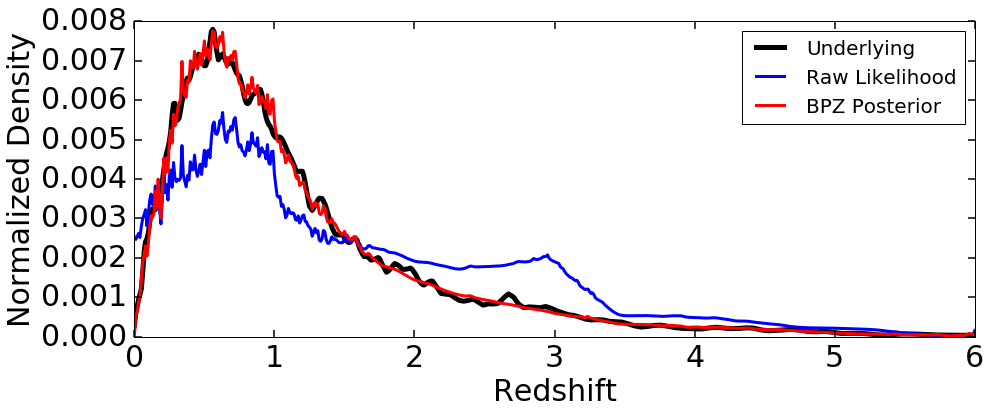

In [17]:
# plotting results
figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_d[sel][::downsample],lzeidx_d[sel][::downsample],
                      ones(Nsub),rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(Uz,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(Uz,z_pdf,lw=5,color='black',label='Underlying')

# computed
plot(Uz,nansum(zpdf_raw,axis=0)/nansum(zpdf_raw),lw=3,color='blue',label='Raw Likelihood')
plot(Uz,nansum(zpdf_bpz,axis=0)/nansum(zpdf_bpz),lw=3,color='red',label='BPZ Posterior')

xlim([Uz.min(),Uz.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Density')

As we would expect, the stacked redshift PDFs computed from the raw likelihoods significantly overestimate the population of high-redshift galaxies (since galaxies are evenly sampled on our grid), while those computed from the BPZ posterior closely follow the underlying distribution. This is what you'd expect given that [1] measured magnitudes are a noisy but unbiased probe of the true magnitudes used to generate the underlying distribution and [2] we've instituted a magnitude cut in the same band we use for the BPZ prior (the $i$-band). 

(A quick note: although we used Luptitudes for our predictions to soften the mapping from flux to magnitude at faint fluxes, the impact this has on the prior is negligible at these magnitudes.)

We can quantify how well the $dN/dz$ distribution generated by the BPZ posterior actually matches the underlying distribution using some functions in the FRANKEN-Z package. 

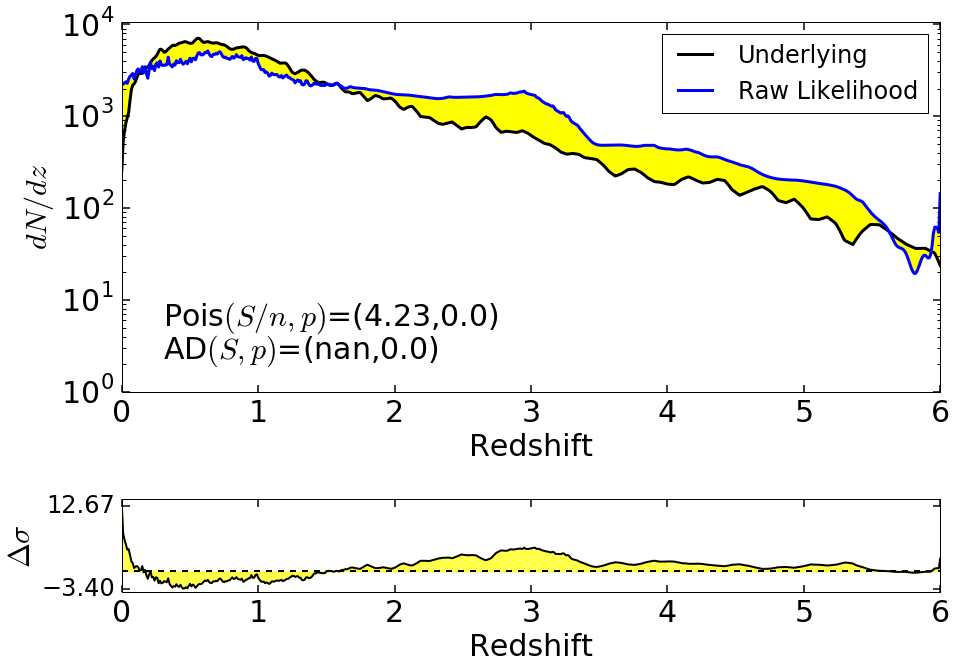

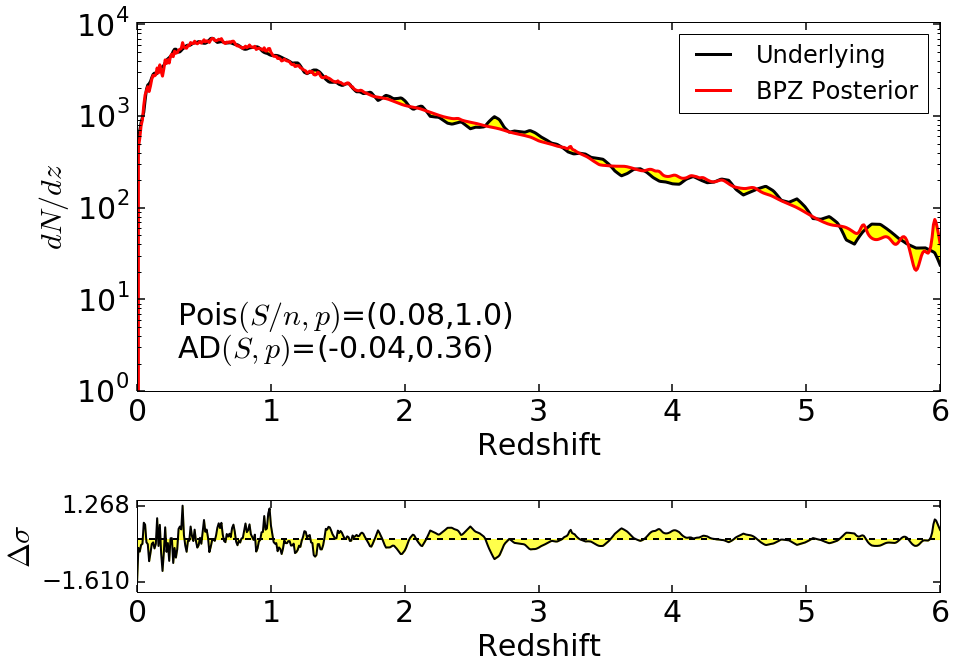

In [34]:
# Raw likelihoods
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*Nsub,nansum(zpdf_raw,axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','Raw Likelihood'],colors=['black','blue'])

# BPZ posteriors
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*Nsub,nansum(zpdf_bpz,axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','BPZ Posterior'],colors=['black','red'])

To elaborate a bit on the metrics:
- One method is to use Poisson counting statistics: if we assume these are number counts that vary randomly, then we can quantify as a function of redshift how much we differ and compute how likely we would see (correlated) fluctuations by chance. This then becomes a simple $\chi^2$ test.
- Alternately, we can do an Anderson-Darling $k=2$-sample test, which broadly compares whether the $k$ observed populations are consistent with the same parent distribution. We use random samples drawn from the $N(z)$ distributions to qualitatively test this.
- Finally, if we are provided with a series of correlated $dN/dz$ draws, we can quantify how well our predicted $N(z)$ agrees with the true distribution compared to the covariance provided by our samples (using either the Mahalanobis distance or naive variance at a given redshift). This is not used above, but we'll come back to this later.

## Likelihood fitting with unbiased training data

Now we move on to the more **realistic case** where we **don't** actually know the underlying models and priors used to generate the data. We assume the **simplest** scenario (rarely true in practice, of course) where the training set is an unbiased sample of the observed data. More complicated scenarios will be dealt with in a following notebook.

In [15]:
# select training/testing samples
ftrain=0.4 # fraction of sample available for training
Ntrain=int(Nsel*ftrain) # number of training objects
Ntest=Nsel-Ntrain
train_sel=zeros(Nsel).astype(bool)
train_sel[choice(Nsel,size=Ntrain,replace=False)]=True # training selection flag
test_sel=(train_sel==False) # testing selection flag

# define training/testing data
phot_train_d,var_train_d,mask_train_d=phot_d[sel][train_sel],var_d[sel][train_sel],mask_d[sel][train_sel] 
phot_test_d,var_test_d,mask_test_d=phot_d[sel][test_sel],var_d[sel][test_sel],mask_d[sel][test_sel]
redshift_train_d,lzidx_train_d,lzeidx_train_d=redshift_d[sel][train_sel],lzidx_d[sel][train_sel],lzeidx_d[sel][train_sel]
redshift_test_d,lzidx_test_d,lzeidx_test_d=redshift_d[sel][test_sel],lzidx_d[sel][test_sel],lzeidx_d[sel][test_sel]

print 'Number of training objects:',Ntrain
print 'Number of testing objects:',Ntest

Number of training objects: 72464
Number of testing objects: 108698


### Scale-free Likelihoods

The first thing we can do is treat these the exact same way we treated the original model grid and just fit them in color space using the **scale-free likelihoods** from before. Note that now using this brute-force calculation is substantially slower since it scales as $\mathcal{O}(N)$ and we've increase the number of "models" by a factor of ~4 (from ~19k to 70k). There's also additional overhead needed to compute the PDFs (although the dictionaries help keep this process efficient) since we have to use KDE over arbitrarily sampled redshifts rather than just summing things over a discrete grid.

In [35]:
downsample=10 # downsample the data since likelihood computation is relatively slow
Nsub=Ntest/downsample+1

# Redshift PDFs and -2ln(evidence) (raw)
lzpdf=empty((Nsub,rdict.Nz))
zpdf=empty((Nsub,Nz))
levidence=empty(Nsub)

sel_arr=arange(Ntest)[::downsample]
for count in arange(Nsub):
    if count%100==0: sys.stdout.write(str(count)+' ')
    i=sel_arr[count]
    ll,Nbands=fz.loglikelihood_s(phot_test_d[i],var_test_d[i],mask_test_d[i],
                                 phot_train_d,var_train_d,mask_train_d) # log-likelihoods and Nbands used in fit 
    llmin=ll.min() # minimum value (for scaling)
    weights=exp(-0.5*(ll-llmin)) # transform to scaled likelihood weights
    levidence[count]=-2*log(weights.sum())+llmin # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train_d,lzeidx_train_d,weights,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[count]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 

Resampling PDFs...0 5000 

10800 

10000 done!


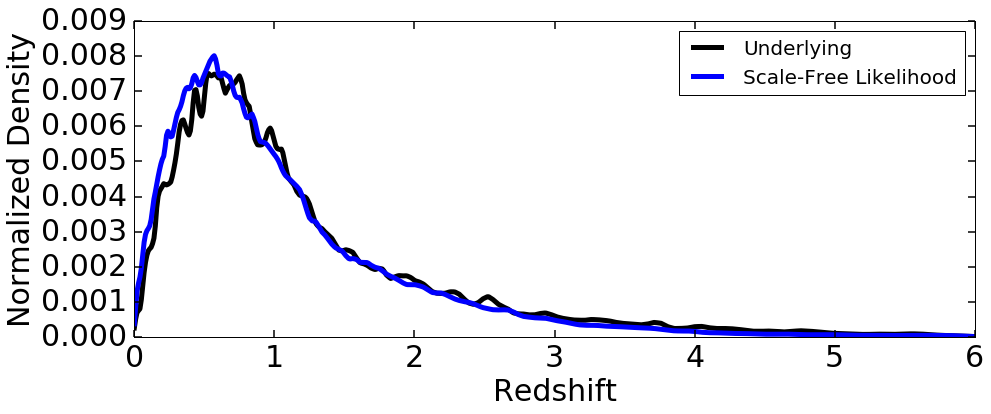

In [36]:
# plotting results
figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test_d[::downsample],lzeidx_test_d[::downsample],
                      ones(Nsub),rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

# computed
plot(rdict.zgrid_out,nansum(zpdf,axis=0)/Nsub,lw=5,color='blue',label='Scale-Free Likelihood')

xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Density')

We notice that while the population distribution on the whole looks reasonable, it is systematically offset from the underlying distribution, with more likelihood concentrated at lower redshifts. This a consequence of better colors being available for brighter galaxies than fainter ones, which systematically upweights their contributions to the likelihood fit relative to the more plentiful fainter galaxies, especially since we ignore measurement errors in the training set photometry in order to render the scale-free likelihood computationally tractable (see Speagle et al. 2017 for more details). The (differential) impact of this on the $N(z)$ distribution is shown below.

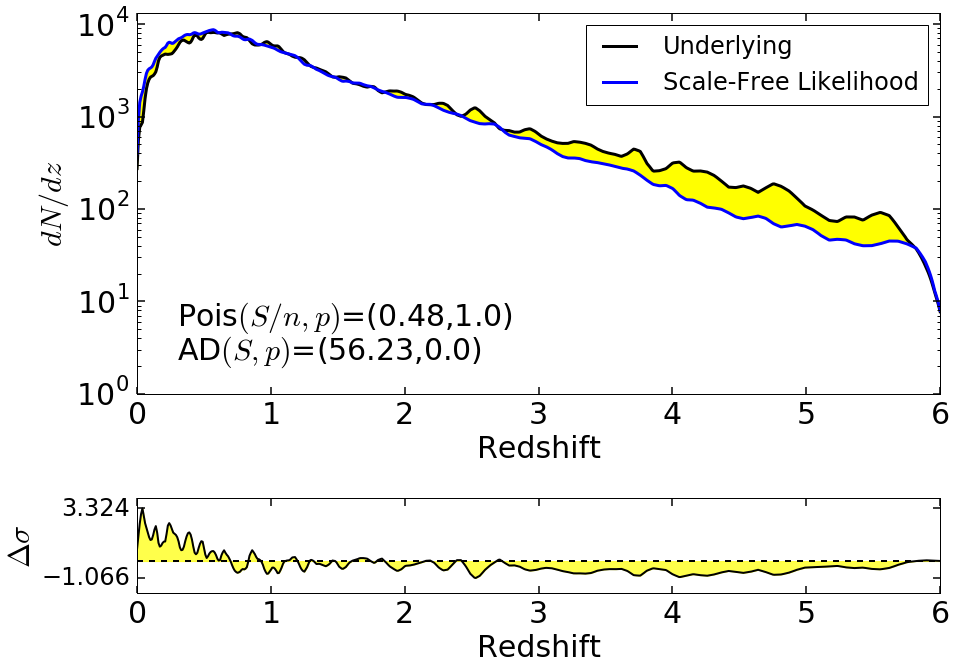

In [37]:
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*Nsub,zpdf.sum(axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','Scale-Free Likelihood'],colors=['black','blue'])

### Scale-dependent Likelihoods

We can attempt to solve this using an *extremely* simple approach: just switch from a scale-free to a **scale-dependent** likelihood (i.e. fitting in flux, not color)! The likelihood then simplifies to just becomes the products of two multivariate Gaussians, giving us a way to analytically incorporate measurement error while simultaneously accounting for magnitude dependencies. It also is quicker to compute.

In [38]:
# Redshift PDFs and -2ln(evidence) (raw)
lzpdf=empty((Nsub,rdict.Nz))
zpdf2=empty((Nsub,Nz))
levidence2=empty(Nsub)

sel_arr=arange(Ntest)[::downsample]
for count in arange(Nsub):
    if count%100==0: sys.stdout.write(str(count)+' ')
    i=sel_arr[count]
    ll,Nbands=fz.loglikelihood(phot_test_d[i],var_test_d[i],mask_test_d[i],
                               phot_train_d,var_train_d,mask_train_d) # log-likelihoods and Nbands used in fit 
    llmin=ll.min() # minimum value (for scaling)
    weights=exp(-0.5*(ll-llmin)) # transform to scaled likelihood weights
    levidence2[count]=-2*log(weights.sum())+llmin # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train_d,lzeidx_train_d,weights,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[count]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf2=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 

Resampling PDFs...0 5000 

10800 

10000 done!


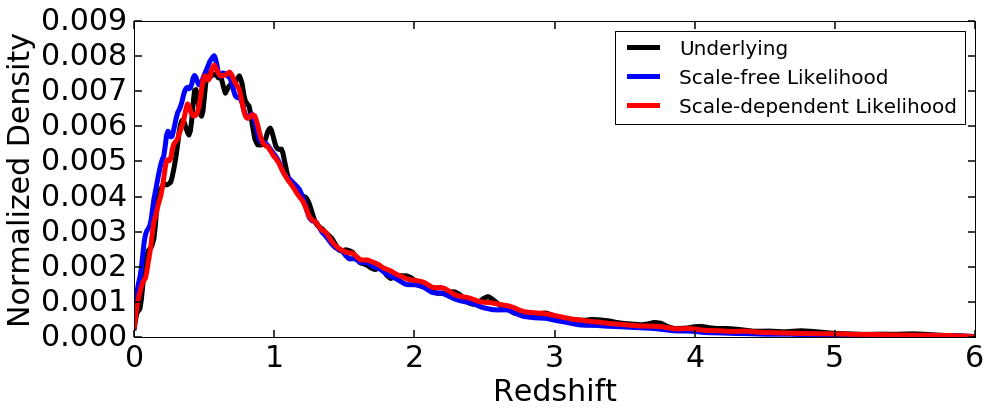

In [39]:
# plotting results
figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test_d[::downsample],lzeidx_test_d[::downsample],
                      ones(Nsub),rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

# computed
plot(rdict.zgrid_out,nansum(zpdf,axis=0)/Nsub,lw=5,color='blue',label='Scale-free Likelihood')
plot(rdict.zgrid_out,nansum(zpdf2,axis=0)/Nsub,lw=5,color='red',label='Scale-dependent Likelihood')

xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Density')

This agrees with the true distribution much better than the previous scale-free case.

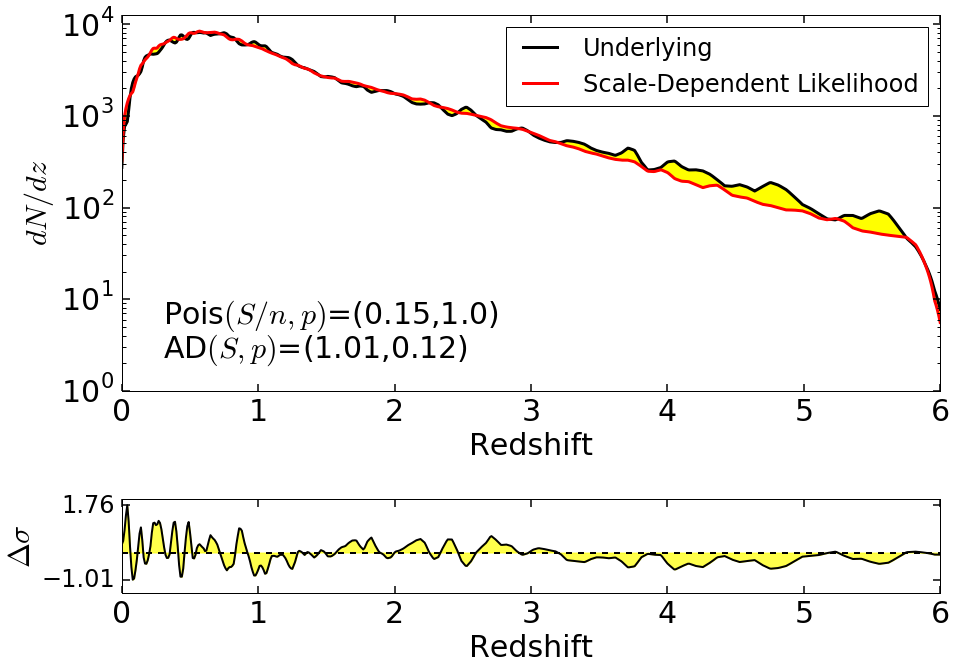

In [40]:
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*Nsub,zpdf2.sum(axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','Scale-Dependent Likelihood'],colors=['black','red'])

## FRANKEN-Z

Now that we've shown that scale-dependent likelihoods are the way to go if you have representative training data, we turn to the computational challenge of exploiting that training data. In particular, taking a brute-force approach (as above) is prohibitively slow, and penalizes you for expanding your training data (which should be something that is rewarded!). 

To really solve this issue, we turn to machine learning. Specifically, we want to develop a **sparse representation of the true likelihood using a small, unbiased set of neighbors**. In other words, we want to select a small ($N_{neighbor} \ll N_{train}$) set of objects and use the likelihood evaluated those as an approximation of the real thing. 

We accomplish this by taking advantage of $k$-$d$ trees to find neighbors in $\mathcal{O}(\log N)$ time, which is a much softer penalty than the $\mathcal{O}(N)$ scaling imposed by brute-force approaches minus the (small) cost of originally constructing the tree. Using an ensemble of $k$-$d$ trees trained/queried with Monte Carlo realizations of the input fluxes, we can guarantee an unbiased selection of (unique) neighbors gathered from across the ensemble that properly takes into account measurement errors on both datasets.

Once we have the sparse representation of the likelihoods in hand, we can then map them onto **any** target distribution using (adaptive) kernel density estimation.

In [41]:
# initialize FRANKEN-Z instance
frankenz=fz.FRANKENZ() # default values: N_MC=100, N_neighbors=10

# generate unique model predictions and corresponding log-likelihoods
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(phot_train_d,sqrt(var_train_d),mask_train_d,
                                                            phot_test_d,sqrt(var_test_d),mask_test_d)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 done!


Note that we actually have generated predictions to the **entire** sample in the same amount of time than it took to generate predictions in the previous brute-force case after significant downsampling.

We now map our model distribution into redshift space.

In [42]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf_fz=empty((Ntest,Nz))
levidence_fz=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    weights=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    levidence_fz[i]=-2*log(weights.sum()/Nm)+model_llmin[i] # -2ln(Evidence), normalized to number of objects used in fit
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train_d[midx],lzeidx_train_d[midx],weights,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf_fz=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 

Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 

108000 

done!


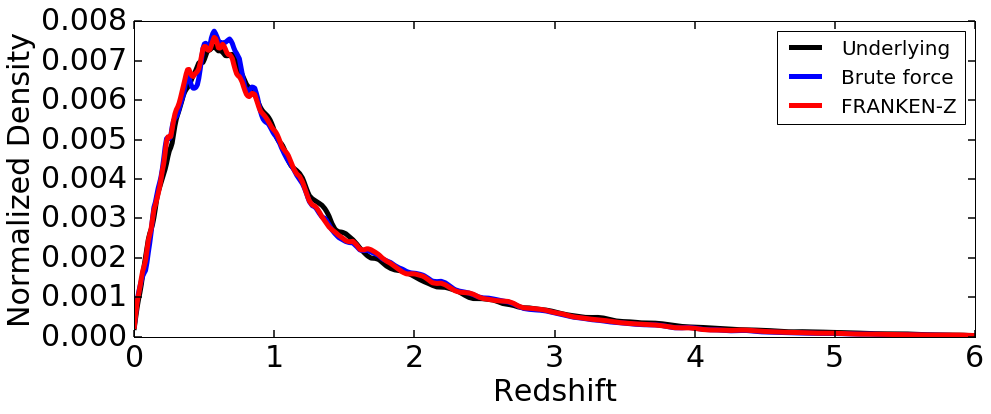

In [43]:
# plotting results
figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test_d,lzeidx_test_d,ones(Ntest),
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

# computed
plot(rdict.zgrid_out,nansum(zpdf2,axis=0)/Nsub,lw=5,color='blue',label='Brute force')
plot(rdict.zgrid_out,nansum(zpdf_fz,axis=0)/Ntest,lw=5,color='red',label='FRANKEN-Z')

xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Density')

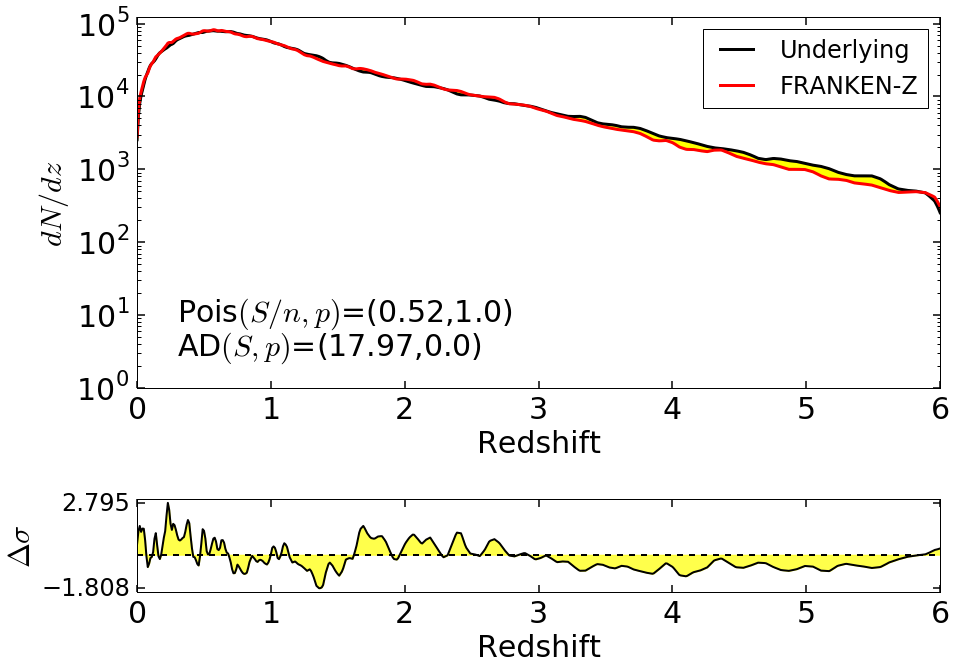

In [46]:
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*Ntest,zpdf_fz.sum(axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','FRANKEN-Z'],colors=['black','red'])

The agreement between the two distributions is quite good overall.